**Data Description**
We recommend
that you number the months, with the earliest starting at zero (0). The last month of the time window is
month eleven (11), which is also the current period, i.e., the present, for the most part of this.

- **cohort** is the group of customers that was acquired in each month. For example, a user
belongs to cohort 3 if s/he was acquired in month 3 (i.e., the 4th month).
- **user** identifies the different users.
- **time_year** is the year and time_month is the month
- **subscription** is binary (1–0) variable that takes on the value one (1) if the user had an (active)
subscription at the time. This variable is always one (1) because we cannot observe the
behavior of users after they cancel their subscription or after they switch to a device other
than their desktop and laptop computers. For the assignment, we define that a user churns if
s/he stops watching Netflix online, i.e., because s/he cancels the subscription or switches to
a different device.
- **content** is the number of different titles (e.g., shows and movies) that a user consumed in a
month.
- **genres** is the number of different genres that are associated with a user’s monthly Netflix
consumption. This variable has a missing value if the user did not use Netflix in a particular
month.
- **recency** is the share of recent content that a user watched in a month. The streaming of a
title is recent if the time between the title’s release date and the date of the stream is less
than two years

## Data Loading and Cleaning

In [107]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# Load data and ensure 'user' is treated as string; drop rows without a user id
data = pd.read_csv("data.csv")
data = data.dropna(subset=['user'])
data['user'] = data['user'].astype(str).str.strip()
data = data[data['user'] != '']

# Create a robust 'date' column from time_year and time_month (day set to 1)
data['time_year'] = pd.to_numeric(data.get('time_year', None), errors='coerce')
data['time_month'] = pd.to_numeric(data.get('time_month', None), errors='coerce')
data['date'] = pd.to_datetime(
    data['time_year'].fillna(0).astype(int).astype(str) + '-' +
    data['time_month'].fillna(1).astype(int).astype(str) + '-01',
    errors='coerce'
)
# drop rows with invalid date
data = data.dropna(subset=['date'])
# create a monthly period column for grouping
data['period'] = data['date'].dt.to_period('M')

# Quick checks
data.info()
data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34475 entries, 0 to 34474
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cohort        34475 non-null  int64         
 1   user          34475 non-null  object        
 2   time_year     34475 non-null  int64         
 3   time_month    34475 non-null  int64         
 4   subscription  34475 non-null  int64         
 5   content       34059 non-null  float64       
 6   genres        34059 non-null  float64       
 7   recency_new   34059 non-null  float64       
 8   bounce        34059 non-null  float64       
 9   date          34475 non-null  datetime64[ns]
 10  period        34475 non-null  period[M]     
dtypes: datetime64[ns](1), float64(4), int64(4), object(1), period[M](1)
memory usage: 2.9+ MB


,cohort,user,time_year,time_month,subscription,content,genres,recency_new,bounce,date,period
count,34475.000000,34475,34475.000000,34475.000000,34475.0,34059.000000,34059.000000,34059.000000,34059.000000,34475,34475
unique,NaN,21440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
top,NaN,1291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02
freq,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3400
mean,5.396461,NaN,2017.380595,6.294329,1.0,3.873249,1.885258,0.371159,0.449736,2017-10-27 04:39:51.298041856,NaN
min,0.000000,NaN,2017.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,2017-05-01 00:00:00,NaN
25%,2.000000,NaN,2017.000000,3.000000,1.0,2.000000,1.000000,0.000000,0.000000,2017-08-01 00:00:00,NaN
50%,6.000000,NaN,2017.000000,6.000000,1.0,3.000000,2.000000,0.333300,0.500000,2017-11-01 00:00:00,NaN
75%,8.000000,NaN,2018.000000,9.000000,1.0,5.000000,2.000000,0.636400,0.692300,2018-02-01 00:00:00,NaN
max,11.000000,NaN,2018.000000,12.000000,1.0,81.000000,5.000000,1.000000,1.000000,2018-04-01 00:00:00,NaN


* Total number of unique users
* New users per month
* Active users per month
* Churned users per month
* Retention rate per month
* Average expected lifetime (in months)
* Distribution summary (% of users active after 3 months, 6 etc)
* Survival Probabilities

## Total number of unique users

In [108]:
# Total unique users in dataset
unique_users = data['user'].nunique()

print("Total unique users:" , unique_users)


Total unique users: 21440


## New users per month (cohort)

In [109]:
# New users per cohort 
#( 'cohort' represents acquisition month

# remove duplicates and then  count per cohort
new_users = data.drop_duplicates(subset=['user']).groupby('cohort')['user'].nunique().sort_index()

print("Total new users per cohort: ")
print(new_users)

Total new users per cohort: 
cohort
0     1791
1     2120
2     1268
3     1788
4     1367
5     1761
6     1806
7     1565
8     1967
9     2066
10    1602
11    2339
Name: user, dtype: int64


## Active Users per month 

In [110]:
# Active users per month using 'period' and 'content' >= 1
active_users = (
    data[ data['content'].fillna(0) >= 1 ]
    .groupby('period')['user']
    .nunique()
    .sort_index()
)
print(active_users)

period
2017-05    1791
2017-06    3152
2017-07    2817
2017-08    2643
2017-09    2528
2017-10    2464
2017-11    2647
2017-12    3040
2018-01    3201
2018-02    3361
2018-03    3144
2018-04    3271
Freq: M, Name: user, dtype: int64


## Churned and retained users per month

In [111]:
# Calcolo churn + retention per period usando 'date'/'period' (fix creazione 'date')
import numpy as np

# Non ricaricare data se già presente; assicurati che time_year/time_month siano numerici
data['time_year'] = pd.to_numeric(data.get('time_year'), errors='coerce')
data['time_month'] = pd.to_numeric(data.get('time_month'), errors='coerce')

# Crea colonna 'date' in modo robusto: usa solo righe con year e month validi
valid = data['time_year'].notna() & data['time_month'].notna()
if valid.any():
    data.loc[valid, 'date'] = pd.to_datetime({
        'year': data.loc[valid, 'time_year'].astype(int),
        'month': data.loc[valid, 'time_month'].astype(int),
        'day': 1
    }, errors='coerce')

data = data.dropna(subset=['date'])  # rimuovi righe senza data valida
data['period'] = data['date'].dt.to_period('M')

# Serie: per ogni period gli user con subscription==1 (array di user unici)
subscribed_by_period = (
    data[data['subscription'] == 1]
    .groupby('period')['user']
    .unique()
    .sort_index()
)

# Itera sui period effettivamente presenti e usa period + 1 (gestisce anno)
periods = list(subscribed_by_period.index.sort_values())
rows = []
for p in periods:
    curr = set(subscribed_by_period.loc[p])
    total = len(curr)
    next_p = p + 1  # pandas.Period addition: aggiunge un mese e gestisce cambio anno
    if next_p in subscribed_by_period.index:
        nxt = set(subscribed_by_period.loc[next_p])
        retained = len(curr & nxt)
        churned = len(curr - nxt)
        retention_rate = retained / total if total > 0 else np.nan
        churn_rate = churned / total if total > 0 else np.nan
    else:
        # se non abbiamo dati per il mese successivo non stimiamo retention/churn
        retained = np.nan
        churned = np.nan
        retention_rate = np.nan
        churn_rate = np.nan
    rows.append({
        'period': p,
        'total_users': total,
        'retained_users': retained,
        'churned_users': churned,
        'retention_rate': retention_rate,
        'churn_rate': churn_rate
    })

churn_dataframe = pd.DataFrame(rows).set_index('period').sort_index()

# Aggiungi nome mese per leggibilità (es: 'January')
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']
churn_dataframe['month_name'] = [month_names[p.to_timestamp().month - 1] for p in churn_dataframe.index]

print('Churn/retention calcolati usando period + 1 month (gestito anno).')
print(churn_dataframe)

Churn/retention calcolati usando period + 1 month (gestito anno).
         total_users  retained_users  churned_users  retention_rate  \
period                                                                
2017-05         1791          1055.0          736.0        0.589056   
2017-06         3175          1597.0         1578.0        0.502992   
2017-07         2865           908.0         1957.0        0.316928   
2017-08         2696          1190.0         1506.0        0.441395   
2017-09         2557           732.0         1825.0        0.286273   
2017-10         2493           890.0         1603.0        0.357000   
2017-11         2696          1516.0         1180.0        0.562315   
2017-12         3081          1265.0         1816.0        0.410581   
2018-01         3232          1334.0         1898.0        0.412748   
2018-02         3400          1588.0         1812.0        0.467059   
2018-03         3190           960.0         2230.0        0.300940   
2018-04    

## Average Expected Lifetime

average expted lifetime calculated as last month of activity per user - first month of activity.

**key assumption**: the user does not return after the last observed month.

Average lifetime (months): 1.6079757462686568
Median lifetime (months): 2.0


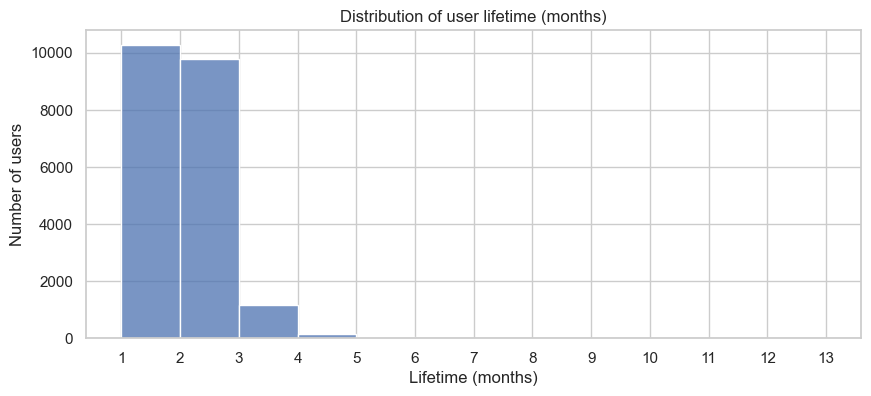

In [112]:
# Compute average observed lifetime (months) using Period subtraction to handle year changes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# use cleaned dataframe 'data' with 'date' column
df = data.dropna(subset=['user','date']).copy()
df['period'] = df['date'].dt.to_period('M')

# primo e ultimo period osservato per user
first_period = df.groupby('user')['date'].min()
last_period = df.groupby('user')['date'].max()


lifetime_months = (last_period.dt.year - first_period.dt.year) * 12 + (last_period.dt.month - first_period.dt.month) + 1

# lifetime in months: difference tra period (gestisce cambio anno) +1 per includere il mese iniziale
#lifetime_months = (last_period - first_period) + 1
#lifetime_months = lifetime_months.clip(lower=0)

average_lifetime = lifetime_months.mean()
median_lifetime = lifetime_months.median()
print('Average lifetime (months):', average_lifetime)
print('Median lifetime (months):', median_lifetime)

# Plot histogram
max_life = int(lifetime_months.dropna().max()) if not lifetime_months.dropna().empty else 1
bins = range(1, max_life + 2)
plt.figure(figsize=(10,4))
sns.histplot(lifetime_months.dropna(), bins=bins, kde=False)
plt.title('Distribution of user lifetime (months)')
plt.xlabel('Lifetime (months)')
plt.ylabel('Number of users')
plt.xticks(bins)
plt.show()

## Quick script to see users with longer lifetime

edit the "threshold" variable and set the number of days.
the script return the users with a lifetime bigger than that.



In [113]:
lifetime = (last_period - first_period) + pd.Timedelta(days=31)

threshold = 100

filtered_users = lifetime[lifetime >= pd.Timedelta(days=threshold)]
filtered_users

user
10272   123 days
10326   123 days
10334   151 days
10369   182 days
10370   182 days
          ...   
961     366 days
9853    213 days
9910    123 days
9922    123 days
9984    123 days
Name: date, Length: 234, dtype: timedelta64[ns]

## Content for user plot



In [114]:
users = data['user'].unique()
periods = data['period'].unique()

content_matrix_dataframe = pd.DataFrame(index=users, columns=periods)

for user in users:
    user_data = data[data['user'] == user]
    for period in periods:
        period_data = user_data[user_data['period'] == period]
        if not period_data.empty:
            content_value = period_data['content'].iloc[0]
            content_matrix_dataframe.at[user, period] = content_value


content_matrix_dataframe = content_matrix_dataframe.fillna(0)

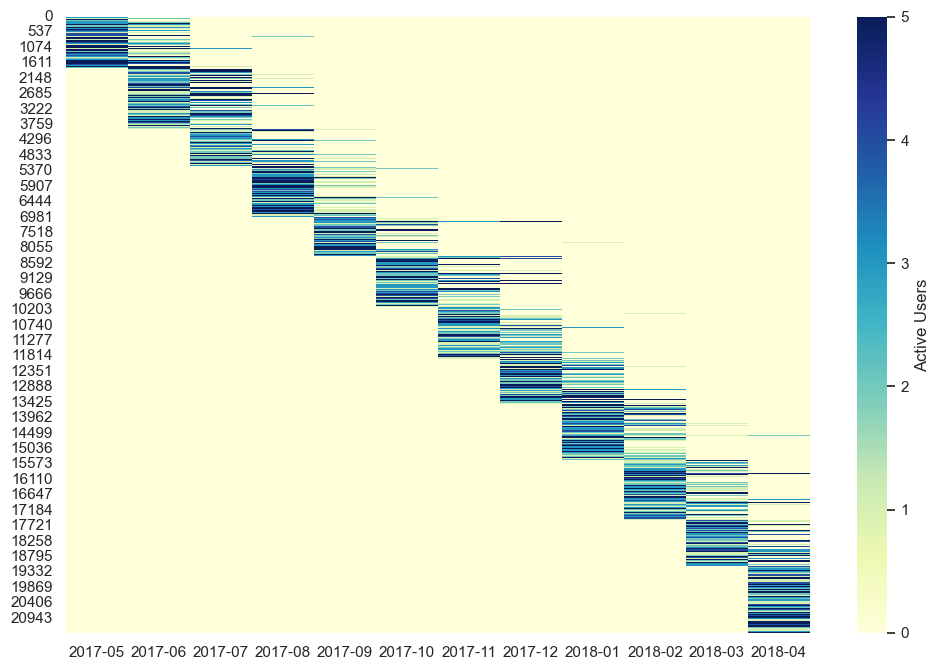

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming active_users_matrix is your data
plt.figure(figsize=(12, 8))  # Increased dimensions: width=12, height=8
sns.heatmap(content_matrix_dataframe, cmap='YlGnBu', cbar_kws={'label': 'Active Users'}, vmin=0, vmax=5)

plt.show()

## Distribution Summary

In [116]:
# Build binary active_users_matrix: 1 se content >= 1 in quel period, 0 altrimenti
df_active = data.copy()
df_active['active'] = (df_active['content'].fillna(0) >= 1).astype(int)
df_active = df_active[['user','period','active']].drop_duplicates()

# pivot in matrix (user x period) con valori 1/0
active_users_matrix = (
    df_active.pivot_table(index='user', columns='period', values='active', aggfunc='max')
    .fillna(0).astype(int)
)

print('Active users matrix built: rows=users, cols=periods')
print(active_users_matrix.shape)


Active users matrix built: rows=users, cols=periods
(21440, 12)


In [117]:
# From active_users_matrix compute % of users still active after k months since first activation (k=1..12)
import numpy as np

# ensure columns are PeriodIndex
cols = active_users_matrix.columns

# find first active period per user (NaT if never active)
def first_active_period(row):
    active_cols = [c for c, v in row.items() if int(v) == 1]
    return active_cols[0] if active_cols else pd.NaT

first_active = active_users_matrix.apply(first_active_period, axis=1)

users = active_users_matrix.index.tolist()
n_users = len(users)

rows = []
for k in range(1, 13):
    active_count = 0
    for u in users:
        fa = first_active.loc[u]
        if pd.isna(fa):
            continue
        target = fa + k  # Period + int aggiunge mesi correttamente
        if target in active_users_matrix.columns:
            if active_users_matrix.at[u, target] == 1:
                active_count += 1
        # se target non esiste, l'utente non è considerato attivo per quel k
    pct = (active_count / n_users * 100) if n_users > 0 else np.nan
    rows.append({'months_after_first_activation': k, 'active_count': int(active_count), 'active_pct': pct})

distribution_k = pd.DataFrame(rows).set_index('months_after_first_activation')
print('Percent of users active after k months since first activation:')

# keep results for later use
distribution_k

Percent of users active after k months since first activation:


,active_count,active_pct
months_after_first_activation,,
1,10910,50.886194
2,1311,6.114739
3,202,0.942164
4,75,0.349813
5,43,0.200560
6,28,0.130597
7,18,0.083955
8,11,0.051306
9,6,0.027985


## Monthly Survival Probability

Monthly survival probabilities (k = months since first activation):
    active_count  survival_prob  survival_pct  conditional_retention
k                                                                   
0          21439       1.000000    100.000000                    NaN
1          10910       0.508886     50.888568               0.508886
2           1311       0.061150      6.115024               0.120165
3            202       0.009422      0.942208               0.154081
4             75       0.003498      0.349830               0.371287
5             43       0.002006      0.200569               0.573333
6             28       0.001306      0.130603               0.651163
7             18       0.000840      0.083959               0.642857
8             11       0.000513      0.051308               0.611111
9              6       0.000280      0.027986               0.545455
10             8       0.000373      0.037315               1.333333
11             8       0.000373    

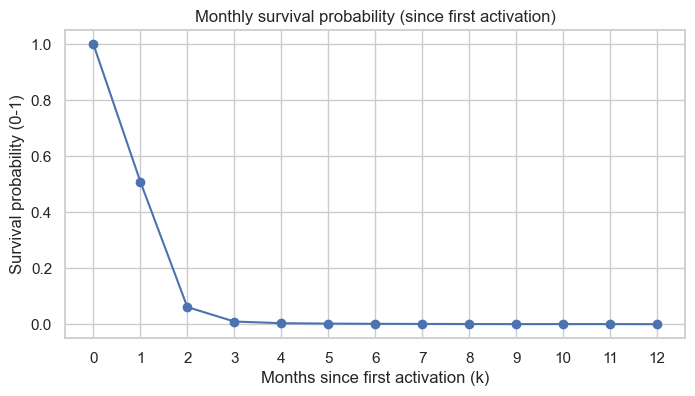

,active_count,survival_prob,survival_pct,conditional_retention
k,,,,
0,21439,1.000000,100.000000,NaN
1,10910,0.508886,50.888568,0.508886
2,1311,0.061150,6.115024,0.120165
3,202,0.009422,0.942208,0.154081
4,75,0.003498,0.349830,0.371287
5,43,0.002006,0.200569,0.573333
6,28,0.001306,0.130603,0.651163
7,18,0.000840,0.083959,0.642857
8,11,0.000513,0.051308,0.611111


In [118]:
# Monthly survival probabilities (k = 0..12) since first activation
import numpy as np
import matplotlib.pyplot as plt

# Binary active table: active = content >= 1
df_active = data.copy()
df_active['active'] = (df_active['content'].fillna(0) >= 1).astype(int)
df_active = df_active[df_active['active'] == 1][['user','period']].drop_duplicates()

# First active period per user
first_active = df_active.groupby('user')['period'].min()
users = first_active.index.to_numpy()
n_users = len(users)

rows = []
for k in range(0, 13):
    # target period per user (Period + int aggiunge mesi correttamente e gestisce cambio anno)
    target_periods = (first_active + k).reindex(users)
    left = pd.DataFrame({'user': users, 'target_period': target_periods.values})
    # merge per verificare attività in target_period
    merged = left.merge(df_active, left_on=['user','target_period'], right_on=['user','period'], how='left', indicator=True)
    active_count = int((merged['_merge'] == 'both').sum())
    survival_prob = active_count / n_users if n_users > 0 else np.nan
    rows.append({
        'k': k,
        'active_count': active_count,
        'survival_prob': survival_prob,
        'survival_pct': survival_prob * 100 if not np.isnan(survival_prob) else np.nan
    })

survival_df = pd.DataFrame(rows).set_index('k')
# Conditional month-to-month retention
survival_df['conditional_retention'] = survival_df['survival_prob'] / survival_df['survival_prob'].shift(1)

print('Monthly survival probabilities (k = months since first activation):')
print(survival_df)

# Plot survival curve
plt.figure(figsize=(8,4))
plt.plot(survival_df.index, survival_df['survival_prob'], marker='o')
plt.title('Monthly survival probability (since first activation)')
plt.xlabel('Months since first activation (k)')
plt.ylabel('Survival probability (0-1)')
plt.xticks(survival_df.index)
plt.grid(True)
plt.show()

# expose survival_df for downstream analysis
survival_df